# Import Model Architectures

Custom Torch Models need to be instantiated for evaluation. The model_architectures.py file contains the model architectures so we can abstract it and focus only on the evaluations.

In [1]:
from model_architectures import *
import torchvision
import model_architectures
from attacks import * 
# Print available classes to verify our model architectures were imported
print(dir(model_architectures))

Using device: cpu
Using device: cpu
['BasicBlock', 'DataLoader', 'F', 'Load', 'ResNetCIFAR', 'ResNetMNIST', 'ResnetSVHN', 'TensorDataset', 'Tester', 'Visualizer', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'cifar_directory', 'conv3x3', 'current_directory', 'device', 'mnist_directory', 'nn', 'np', 'os', 'pd', 'pickle', 'plt', 'scipy', 'svhn_directory', 'torch']


# Loading the Model Weights

Using our model artifacts we load the weights back into the model so we have our pre-trained models to test our perturbations against.

In [2]:
mnist_resnet_model = ResNetMNIST(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=True).to(device)
cifar_resnet_model = ResNetCIFAR(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)
svhn_resnet_model = ResnetSVHN(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)

#add map_location=torch.device('cpu') if running locally and ur not sai lol
mnist_resnet_model.load_state_dict(torch.load("artifacts/resnet18_mnist_model.pth", map_location=torch.device('cpu')))
cifar_resnet_model.load_state_dict(torch.load("artifacts/resnet18_cifar_model.pth", map_location=torch.device('cpu')))
svhn_resnet_model.load_state_dict(torch.load("artifacts/resnet18_svhn_model.pth",map_location=torch.device('cpu')))

<All keys matched successfully>

In [3]:
# Set models to evaluation mode
mnist_resnet_model.eval()
cifar_resnet_model.eval()
svhn_resnet_model.eval()

ResnetSVHN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

In [4]:
loader = Load()
mnist_test_images, mnist_test_labels = loader.load_mnist_test_images()
cifar10_test_images, cifar10_test_labels = loader.load_cifar10_test_images()
svhn_test_images, svhn_test_labels = loader.load_svhn_test_images()

In [5]:
test_loader_mnist = loader.convert_mnist_numpy_to_tensor(mnist_test_images[:256], mnist_test_labels[:256])
test_loader_cifar10 = loader.convert_cifar10_numpy_to_tensor(cifar10_test_images[:256], cifar10_test_labels[:256])
test_loader_svhn = loader.convert_svhn_numpy_to_tensor(svhn_test_images[:256], svhn_test_labels[:256])
tester = Tester()

In [6]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

# Jacobian Saliency Map Attack

The jacobian saliency map attack is a white box attack that takes in the inputs: target class; theta, the change made to pixels within the image; and upsilon, the maximum distortion allowed to the image. JSMA operates relatively intuitively; it is an iterative attack that utilizes the "saliency map" of an image (in computer vision, the saliency map of an image is the concentration of pixels on which people's eyes focus on first) to distort the image enough so that it is interpreted as the target class by the model

The pixels in question that will experience the perturbation will constantly be modified by some value theta, iteratively.

In [7]:
print("Attack Image & Predicted Label")
viz = Visualizer()


def test_jsma(model, test_loader):
    model.eval()

    pred_list = []
    correct = 0
    total = 0
    adv_examples = []

    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        target = 3
        for image, label in zip(images, labels):
            image = image.unsqueeze(0)
            label = label.unsqueeze(0)

            output, _ = model(image)

            # print(outputs)

            _, init_pred = torch.max(output.data, 1)
            

            
            advimages = jsma_attack(model, image, 3, 10)
            output_adv, _ = model(advimages)
            #advimages = advimages[0,:,:,:] / 255

            #print(advimages.shape)
            #viz.show(advimages.detach())
            
            _, prediction_adv = torch.max(output_adv.data, 1)

            if torch.equal(prediction_adv, label):
                correct += 1
            else:
                # Save some adv examples for visualization later
                #if len(adv_examples) < 5:
                    #if prediction_adv not in pred_list:
                adv_ex = advimages.squeeze().detach().cpu().numpy()

                adv_examples.append( (init_pred, prediction_adv, adv_ex) )
                pred_list.append(prediction_adv)

                        
            total +=1 
            print(correct, "/", total)  
            
    print('Accuracy of test text: %f %%' % ((float(correct) / total) * 100))
    return adv_examples


Attack Image & Predicted Label


In [8]:
adv_examples = test_jsma(mnist_resnet_model, test_loader_mnist)

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


0 / 1
0 / 2
0 / 3
0 / 4
0 / 5
0 / 6
0 / 7
0 / 8
0 / 9
1 / 10
1 / 11
1 / 12
1 / 13
1 / 14
1 / 15
1 / 16
2 / 17
2 / 18
3 / 19
3 / 20
3 / 21
3 / 22
4 / 23
4 / 24
5 / 25
5 / 26
5 / 27
5 / 28
5 / 29
5 / 30
6 / 31
6 / 32
7 / 33
7 / 34
7 / 35
7 / 36
7 / 37
8 / 38
8 / 39
8 / 40
8 / 41
8 / 42
8 / 43
9 / 44
10 / 45
11 / 46
12 / 47
12 / 48
12 / 49
12 / 50
12 / 51
13 / 52
13 / 53
13 / 54
13 / 55
13 / 56
13 / 57
13 / 58
13 / 59
13 / 60
13 / 61
13 / 62
13 / 63
14 / 64
14 / 65
14 / 66
14 / 67
14 / 68
15 / 69
15 / 70
15 / 71
15 / 72
15 / 73
15 / 74
15 / 75
16 / 76
17 / 77
17 / 78
17 / 79
17 / 80
18 / 81
18 / 82
18 / 83
18 / 84
18 / 85
18 / 86
18 / 87
19 / 88
19 / 89
19 / 90
20 / 91
21 / 92
21 / 93
22 / 94
22 / 95
22 / 96
22 / 97
23 / 98
23 / 99
23 / 100
23 / 101
24 / 102
24 / 103
24 / 104
25 / 105
25 / 106
25 / 107
25 / 108
25 / 109
25 / 110
25 / 111
25 / 112
26 / 113
26 / 114
26 / 115
26 / 116
26 / 117
27 / 118
27 / 119
27 / 120
27 / 121
27 / 122
28 / 123
29 / 124
29 / 125
29 / 126
29 / 127
29 / 128


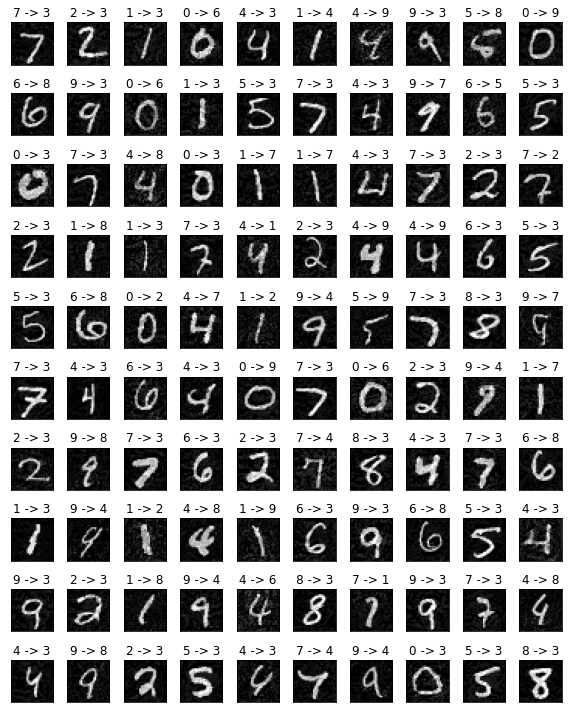

In [9]:
plt.figure(figsize=(8, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = adv_examples[j]
    plt.title(f"{orig.item()} -> {adv.item()}")
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [10]:
adv_examples = test_jsma(svhn_resnet_model, test_loader_svhn)

0 / 1
0 / 2
0 / 3
0 / 4
0 / 5
0 / 6
0 / 7
0 / 8
0 / 9
0 / 10
1 / 11
1 / 12
1 / 13
1 / 14
1 / 15
1 / 16
1 / 17
1 / 18
2 / 19
2 / 20
2 / 21
2 / 22
2 / 23
3 / 24
3 / 25
3 / 26
3 / 27
3 / 28
3 / 29
3 / 30
3 / 31
4 / 32
4 / 33
4 / 34
4 / 35
4 / 36
4 / 37
4 / 38
4 / 39
4 / 40
4 / 41
4 / 42
4 / 43
4 / 44
4 / 45
4 / 46
4 / 47
4 / 48
4 / 49
4 / 50
4 / 51
4 / 52
5 / 53
5 / 54
5 / 55
5 / 56
5 / 57
5 / 58
5 / 59
5 / 60
5 / 61
5 / 62
5 / 63
5 / 64
5 / 65
5 / 66
5 / 67
5 / 68
6 / 69
6 / 70
7 / 71
7 / 72
7 / 73
7 / 74
7 / 75
7 / 76
7 / 77
7 / 78
8 / 79
9 / 80
9 / 81
9 / 82
9 / 83
9 / 84
9 / 85
9 / 86
9 / 87
9 / 88
9 / 89
9 / 90
9 / 91
9 / 92
9 / 93
9 / 94
9 / 95
9 / 96
9 / 97
9 / 98
9 / 99
9 / 100
9 / 101
9 / 102
9 / 103
10 / 104
10 / 105
10 / 106
11 / 107
11 / 108
11 / 109
12 / 110
13 / 111
13 / 112
13 / 113
14 / 114
14 / 115
14 / 116
14 / 117
14 / 118
14 / 119
15 / 120
15 / 121
15 / 122
15 / 123
15 / 124
15 / 125
15 / 126
16 / 127
16 / 128
16 / 129
16 / 130
16 / 131
16 / 132
16 / 133
16 / 134
16 / 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

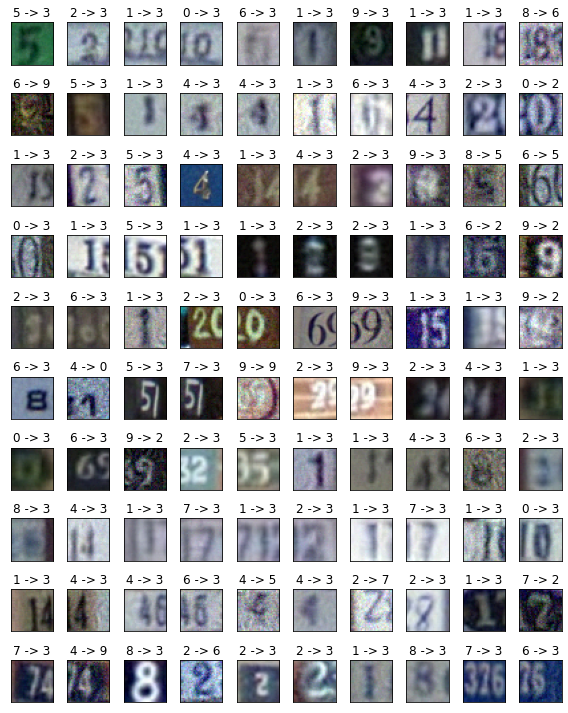

In [11]:
# Test visualizer with an image available in test data
viz = Visualizer()
label_mapping2 = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9'
}

# Test visualizer with an image available in test data
viz = Visualizer()

plt.figure(figsize=(8, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = adv_examples[j]
    ex = np.transpose(ex, (1, 2, 0))  # Changing shape to (32, 32, 3) for imshow
    ex = ex # /255 # Normalizing pixel values
    plt.title(f"{orig.item()} -> {adv.item()}")
    plt.imshow(ex)
plt.tight_layout()
plt.show()

In [12]:
adv_examples = test_jsma(cifar_resnet_model, test_loader_cifar10)

1 / 1
2 / 2
2 / 3
2 / 4
2 / 5
3 / 6
3 / 7
3 / 8
4 / 9
4 / 10
4 / 11
4 / 12
4 / 13
4 / 14
4 / 15
4 / 16
4 / 17
4 / 18
4 / 19
4 / 20
4 / 21
5 / 22
5 / 23
6 / 24
6 / 25
6 / 26
6 / 27
7 / 28
7 / 29
7 / 30
7 / 31
7 / 32
7 / 33
7 / 34
8 / 35
8 / 36
8 / 37
8 / 38
8 / 39
8 / 40
9 / 41
9 / 42
9 / 43
9 / 44
9 / 45
9 / 46
10 / 47
10 / 48
10 / 49
10 / 50
10 / 51
10 / 52
10 / 53
11 / 54
11 / 55
12 / 56
12 / 57
12 / 58
12 / 59
12 / 60
13 / 61
14 / 62
14 / 63
15 / 64
15 / 65
15 / 66
15 / 67
16 / 68
17 / 69
18 / 70
18 / 71
18 / 72
18 / 73
18 / 74
19 / 75
19 / 76
19 / 77
20 / 78
21 / 79
21 / 80
21 / 81
21 / 82
21 / 83
21 / 84
21 / 85
21 / 86
21 / 87
21 / 88
21 / 89
21 / 90
22 / 91
23 / 92
24 / 93
24 / 94
24 / 95
24 / 96
25 / 97
25 / 98
25 / 99
25 / 100
25 / 101
25 / 102
25 / 103
26 / 104
26 / 105
26 / 106
27 / 107
28 / 108
28 / 109
28 / 110
28 / 111
28 / 112
28 / 113
28 / 114
29 / 115
30 / 116
30 / 117
30 / 118
30 / 119
30 / 120
30 / 121
31 / 122
32 / 123
32 / 124
32 / 125
32 / 126
32 / 127
33 / 128
33

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

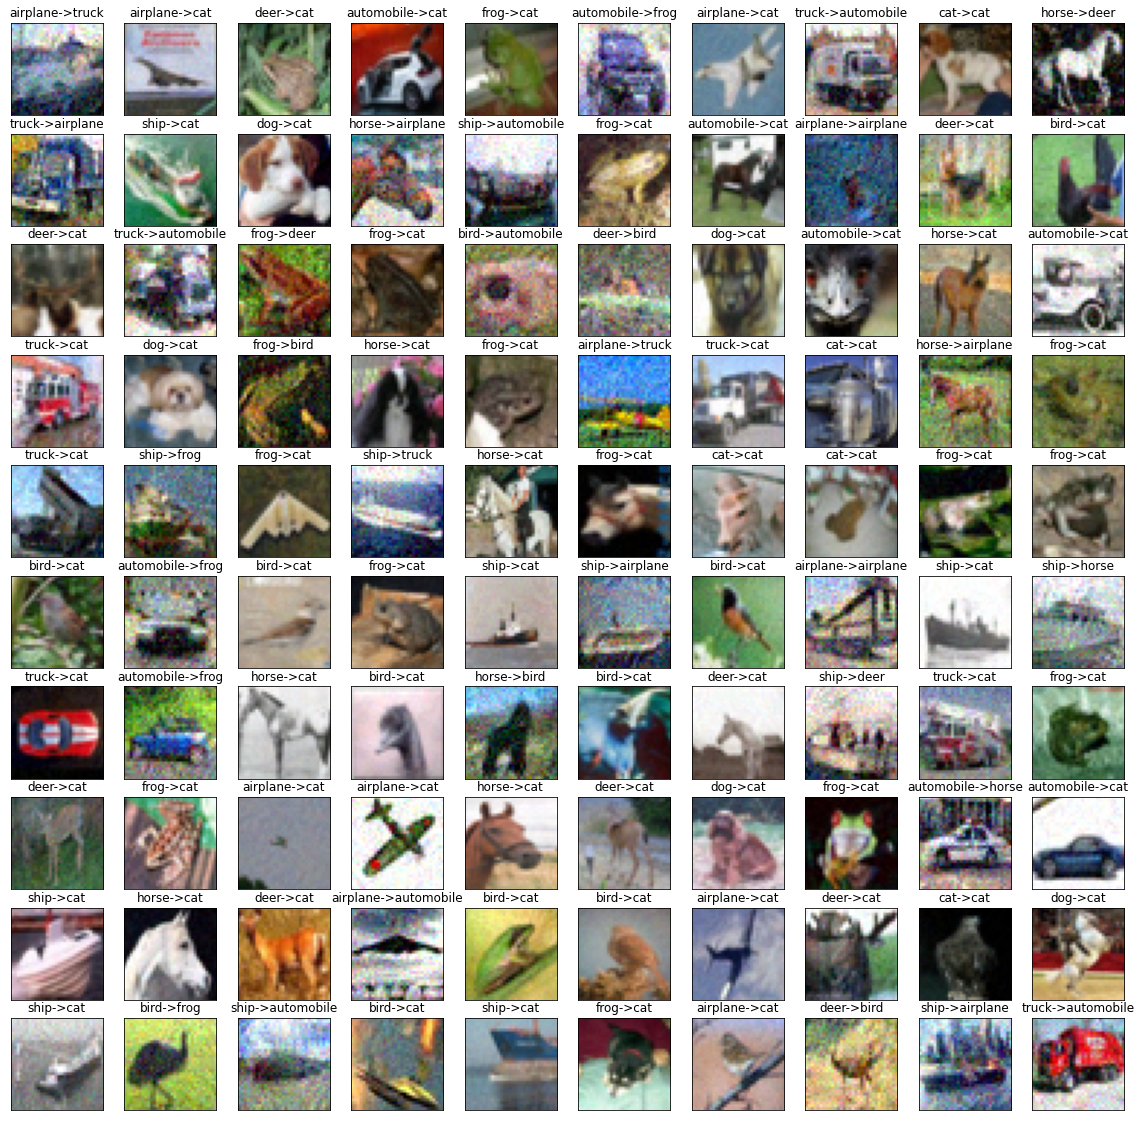

In [13]:
# CIFAR-10
label_mapping = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

plt.figure(figsize=(20, 20))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = adv_examples[j]
    ex = np.transpose(ex, (1, 2, 0))  # Changing shape to (32, 32, 3) for imshow
    ex = ex  # Normalizing pixel values
    plt.title(f"{label_mapping[orig.item()]}->{label_mapping[adv.item()]}")
    plt.imshow(ex)

plt.show()
